---
title: "Anomaly Detection"
description: "Anomaly Detection identifies unusual patterns or outliers in data, crucial for detecting deviations from the norm and highlighting potential irregularities or abnormalities."
author: "Vraj Shah"
date: "9/24/2023"
---

### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Dataset

In [2]:
X_train = np.load("data/X_train.npy")
X_test = np.load("data/X_test.npy")
y_test = np.load("data/y_test.npy")

In [3]:
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)

(307, 2)
(307, 2)
(307,)


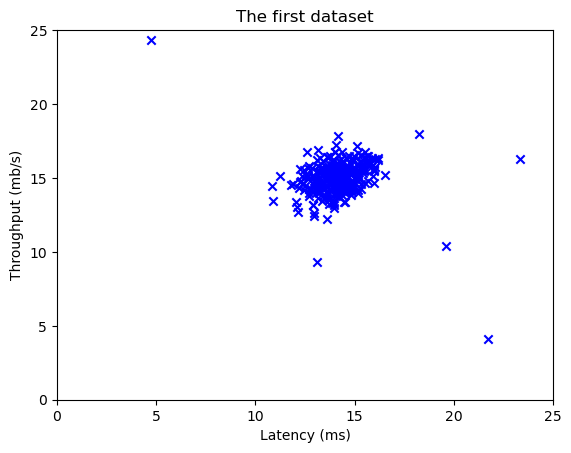

In [4]:
plt.scatter(X_train[:, 0], X_train[:, 1], marker='x', c='b')

plt.title("The first dataset")
plt.ylabel('Throughput (mb/s)')
plt.xlabel('Latency (ms)')
plt.axis([0, 25, 0, 25])
plt.show()

### Gaussian Distribution

$$
p(x ; \mu,\sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}} \exp \left( - \frac{(x - \mu)^2}{2 \sigma ^2} \right)
$$

$$
\text{(Univariate Gaussian Distribution)}
$$

$$
p(\mathbf{x}; \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \frac{1}{(2\pi)^{k/2} |\boldsymbol{\Sigma}|^{1/2}} \exp\left(-\frac{1}{2} (\mathbf{x} - \boldsymbol{\mu})^T \boldsymbol{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu})\right)
$$

$$
\boldsymbol{\Sigma} = \begin{bmatrix}
    \sigma_{1}^2 & \sigma_{12} & \sigma_{13} & \ldots & \sigma_{1k} \\
    \sigma_{21} & \sigma_{2}^2 & \sigma_{23} & \ldots & \sigma_{2k} \\
    \sigma_{31} & \sigma_{32} & \sigma_{3}^2 & \ldots & \sigma_{3k} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    \sigma_{k1} & \sigma_{k2} & \sigma_{k3} & \ldots & \sigma_{k}^2 \\
\end{bmatrix}
$$

$$
\text{(Multivariate Gaussian Distribution)}
$$

In [5]:
def estimate_gaussian(X):

    mu = np.mean(X, axis=0)
    var = np.var(X, axis=0)

    return mu, var

In [6]:
def univariate_gaussian(X, mu, var):

    p = (1 / (np.sqrt(2 * np.pi * var))) * np.exp(-((X - mu) ** 2) / (2 * var))

    return p

In [7]:
def multivariate_gaussian(X, mu, var):

    k = len(mu)

    if var.ndim == 1:
        var = np.diag(var)

    X = X - mu
    p = (2 * np.pi)**(-k/2) * np.linalg.det(var)**(-0.5) * \
        np.exp(-0.5 * np.sum(np.matmul(X, np.linalg.pinv(var)) * X, axis=1))

    return p

In [8]:
mu, var = estimate_gaussian(X_train)
print("mu = ", mu)
print("var = ", var)

mu =  [14.11222578 14.99771051]
var =  [1.83263141 1.70974533]


In [9]:
print(univariate_gaussian(X_train[246][0], mu[0], var[0]))

0.28071685840987737


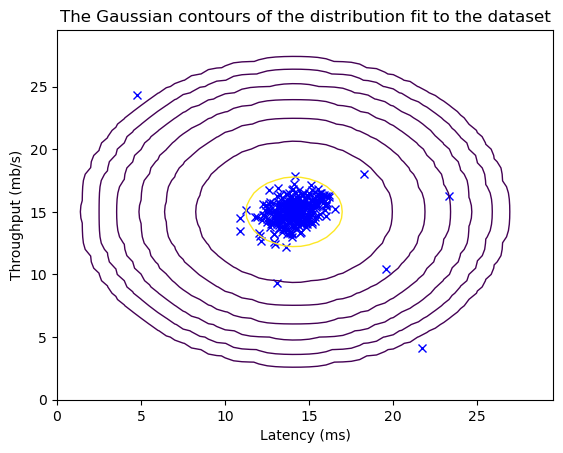

In [10]:
X1, X2 = np.meshgrid(np.arange(0, 30, 0.5), np.arange(0, 30, 0.5))
Z = multivariate_gaussian(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, var)
Z = Z.reshape(X1.shape)

plt.plot(X_train[:, 0], X_train[:, 1], 'bx')
plt.contour(X1, X2, Z, levels=10**(np.arange(-20., 1, 3)), linewidths=1)

plt.title("The Gaussian contours of the distribution fit to the dataset")
plt.ylabel('Throughput (mb/s)')
plt.xlabel('Latency (ms)')
plt.show()

### Selecting threshold $\epsilon$
$$\begin{aligned} prec&=\frac{tp}{tp+fp} \\ rec &=\frac{tp}{tp+fn},\end{aligned}$$
$$F_1 = \frac{2\cdot prec \cdot rec}{prec + rec}$$ 

In [11]:
def select_threshold(y_val, p_val):
    best_epsilon = 0
    best_F1 = 0
    F1 = 0

    step_size = (max(p_val) - min(p_val)) / 1000

    for epsilon in np.arange(min(p_val), max(p_val), step_size):

        predictions = (p_val < epsilon)

        tp = np.sum((predictions == 1) & (y_val == 1))
        fp = np.sum((predictions == 1) & (y_val == 0))
        fn = np.sum((predictions == 0) & (y_val == 1))

        prec, rec = 0, 0

        if (tp+fp) != 0:
            prec = (tp)/(tp+fp)
        if (tp+fn) != 0:
            rec = (tp)/(tp+fn)

        F1 = 0
        if (prec+rec) != 0:
            F1 = 2*prec*rec/(prec+rec)

        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon

    return best_epsilon, best_F1

### Finding Outliers

In [12]:
p = multivariate_gaussian(X_train, mu, var)
p_val = multivariate_gaussian(X_test, mu, var)
epsilon, F1 = select_threshold(y_test, p_val)

print('Best epsilon found using cross-validation: %e' % epsilon)
print('Best F1 on Cross Validation Set: %f' % F1)

Best epsilon found using cross-validation: 8.990853e-05
Best F1 on Cross Validation Set: 0.875000


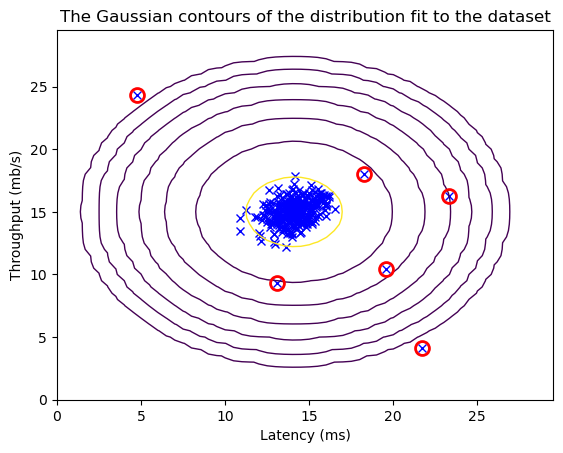

# Anomalies found: 6


In [13]:
outliers = p < epsilon

X1, X2 = np.meshgrid(np.arange(0, 30, 0.5), np.arange(0, 30, 0.5))
Z = multivariate_gaussian(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, var)
Z = Z.reshape(X1.shape)

plt.plot(X_train[:, 0], X_train[:, 1], 'bx')
plt.contour(X1, X2, Z, levels=10**(np.arange(-20., 1, 3)), linewidths=1)
plt.plot(X_train[outliers, 0], X_train[outliers, 1], 'ro',
         markersize=10, markerfacecolor='none', markeredgewidth=2)

plt.title("The Gaussian contours of the distribution fit to the dataset")
plt.ylabel('Throughput (mb/s)')
plt.xlabel('Latency (ms)')
plt.show()

print('# Anomalies found: %d' % sum(p < epsilon))